# Getting Familiar with the data

Import Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

Import & view data

In [2]:
cs = pd.read_csv('./train.csv') #cs == car_spreadsheet
cs.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


See what data types we're working with

In [3]:
print(cs.dtypes)

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


## Cleaning the data

Find price outliers using Z score

In [4]:
def detect_outliers(data):
    outlier_values=[]
    threshold=3
    mean=np.mean(data)
    std=np.std(data)
    
    for i in range(len(data)):
        z_score = (data[i] - mean)/std
        if np.abs(z_score) > threshold:
            outlier_values.append(data[i])
    return outlier_values

In [5]:
outliers=detect_outliers(cs.Price)
print(f"Our price outliers are {outliers}")

Our price outliers are [627220, 872946, 26307500]


Remove the outliers from our dataset

In [6]:
for i in outliers:
    cs.drop(index=cs[cs['Price'] == i].index)

Drop unnecessary columns and reformat object columns needed for our heatmap into usable int/float datatypes

In [7]:
def drop_columns(df, levy_median=781):    
    df.drop(['Manufacturer', 'Model', 'Doors'], axis=1, inplace=True)
    df['Leather interior'] = df['Leather interior'].str.contains('Yes').astype(int)
    df['Mileage'] = df['Mileage'].str.replace('km', '').astype(int)
    df['Levy'] = df['Levy'].replace('-', 781).astype(int)
    df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '').astype(float)
    return df

In [8]:
train_prepared = drop_columns(cs)

test_sheet = pd.read_csv('./test.csv')
test_prepared = drop_columns(test_sheet)

Ensure we have the correct variable types for our heatmap

In [9]:
print(cs.dtypes)

ID                    int64
Price                 int64
Levy                  int32
Prod. year            int64
Category             object
Leather interior      int32
Fuel type            object
Engine volume       float64
Mileage               int32
Cylinders           float64
Gear box type        object
Drive wheels         object
Wheel                object
Color                object
Airbags               int64
dtype: object


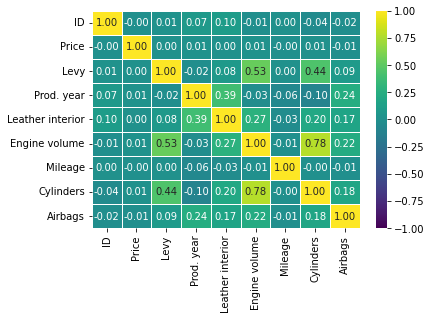

In [10]:
heatmap = sns.heatmap(cs.corr(), cmap='viridis', vmax=1, vmin=-1, annot=True, linewidth=1, fmt='.2f')

### * Strong correlation between **Engine** **volume** and **# of cylinders**
### * **Levy** also correlated with both **Engine** **volume** and **# of cylinders**
### * No correlation between **Price** and any other variable

# Encode data for model

Our model only accepts numerical values, so we'll need to convert our objects into numbers using label encoding

First, let's separate our already-numerical data from data that we plan to encode

In [11]:
train_prepared_numeric = train_prepared.select_dtypes(np.number)  

Next, let's transform our columns with object datatypes into number arrays

In [12]:
train_prepared_categorical = train_prepared.select_dtypes(object)
encoder = OrdinalEncoder()
train_cat_encoded = encoder.fit_transform(train_prepared_categorical)

And bring those arrays back together into a data frame

In [13]:
cat_df=pd.DataFrame(train_cat_encoded, columns=train_prepared_categorical.columns)
cat_df.head()

,Category,Fuel type,Gear box type,Drive wheels,Wheel,Color
0,4.0,2.0,0.0,0.0,0.0,12.0
1,4.0,5.0,2.0,0.0,0.0,1.0
2,3.0,5.0,3.0,1.0,1.0,1.0
3,4.0,2.0,0.0,0.0,0.0,14.0
4,3.0,5.0,0.0,1.0,0.0,12.0


Let's join our old numerical table and new numerical table together into one table

In [14]:
concat=pd.concat([train_prepared_numeric,cat_df],axis=1)

In [15]:
X = concat.drop(['Price'], axis=1).copy()
y = concat['Price'].values

And finally split our data into different sets (70% for training and 30% for testing)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

## Random Forest Model

We have multiple variables (Mileage, cylinders, etc.) affecting the "predicted price" of our vehicles, so we can't use a linear regression model

And a single decision tree would rely too much on the training data

So let's use a RF Regression model that will randomly sample from our data and form a forest of decision trees that will determine our results

In [17]:
model = RandomForestRegressor(random_state=3)

In [18]:
model.fit(X_train, y_train)
print(f'Train RMSLE: {np.sqrt(mean_squared_log_error(model.predict(X_train), y_train))}')
print(f'Val RMSLE: {np.sqrt(mean_squared_log_error(model.predict(X_val), y_val))}')

Train RMSLE: 0.7538510792251315
Val RMSLE: 1.0505255538648994


Below, we're just encoding our data for our test set in the same way we did for our training set.

In [19]:
test_prep_num = test_prepared.select_dtypes(np.number)
test_cat = test_prepared.select_dtypes(object)
test_enc_cat = encoder.transform(test_cat)
test_cat_df=pd.DataFrame(test_enc_cat, columns=test_cat.columns)
concat_test = pd.concat([test_prep_num, test_cat_df], axis=1)
X_test = concat_test.drop(['Price'], axis=1).copy()

Let's see our results!

In [20]:
sample_results = pd.read_csv('./sample_results.csv')
sample_results['Price'] = model.predict(X_test)
sample_results.head()

,Price
0,21488.43
1,18204.62
2,7879.62
3,13121.42
4,2871.45


This dataset was provided by Kaggle! 